In [34]:
from __future__ import print_function

''' 
Classify sounds using database
Author: Scott H. Hawley

This is kind of a mixture of Keun Woo Choi's code https://github.com/keunwoochoi/music-auto_tagging-keras
   and the MNIST classifier at https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

Trained using Fraunhofer IDMT's database of monophonic guitar effects, 
   clips were 2 seconds long, sampled at 44100 Hz
'''

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils
import os
from os.path import isfile

from timeit import default_timer as timer

mono=True


def get_class_names(path="Preproc/"):  # class names are subdirectory names in Preproc/ directory
    class_names = os.listdir(path)
    class_names.remove(".DS_Store")
    return class_names

def get_total_files(path="Preproc/",train_percentage=0.8): 
    sum_total = 0
    sum_train = 0
    sum_test = 0
    subdirs = os.listdir(path)
    subdirs.remove(".DS_Store")

    for subdir in subdirs:
        files = os.listdir(path+subdir)
        # files.remove(".DS_Store")
        n_files = len(files)
        sum_total += n_files
        n_train = int(train_percentage*n_files)
        n_test = n_files - n_train
        sum_train += n_train
        sum_test += n_test
    return sum_total, sum_train, sum_test

def get_sample_dimensions(path='Preproc/'):
    classnames = os.listdir(path)
    classnames.remove(".DS_Store")
    classname = classnames[0]
    files = os.listdir(path+classname)
    # files.remove(".DS_Store")
    infilename = files[0]
    audio_path = path + classname + '/' + infilename
    melgram = np.load(audio_path)
    print("   get_sample_dimensions: melgram.shape = ",melgram.shape)
    return melgram.shape
 

def encode_class(class_name, class_names):  # makes a "one-hot" vector for each class name called
    try:
        idx = class_names.index(class_name)
        vec = np.zeros(len(class_names))
        vec[idx] = 1
        return vec
    except ValueError:
        return None

def shuffle_XY_paths(X,Y,paths):   # generates a randomized order, keeping X&Y(&paths) together
    assert (X.shape[0] == Y.shape[0] )
    idx = np.array(range(Y.shape[0]))
    np.random.shuffle(idx)
    newX = np.copy(X)
    newY = np.copy(Y)
    newpaths = paths
    for i in range(len(idx)):
        newX[i] = X[idx[i],:,:]
        newY[i] = Y[idx[i],:]
        newpaths[i] = paths[idx[i]]
    return newX, newY, newpaths


'''
So we make the training & testing datasets here, and we do it separately.
Why not just make one big dataset, shuffle, and then split into train & test?
because we want to make sure statistics in training & testing are as similar as possible
'''
def build_datasets(train_percentage=0.8, preproc=False):
    if (preproc):
        path = "Preproc/"
    else:
        path = "Samples/"

    class_names = get_class_names(path=path)
    print("class_names = ",class_names)

    total_files, total_train, total_test = get_total_files(path=path, train_percentage=train_percentage)
    print("total files = ",total_files)

    nb_classes = len(class_names)

    # pre-allocate memory for speed (old method used np.concatenate, slow)
    mel_dims = get_sample_dimensions(path=path)  # Find out the 'shape' of each data file
    X_train = np.zeros((total_train, mel_dims[1], mel_dims[2], mel_dims[3]))   
    Y_train = np.zeros((total_train, nb_classes))  
    X_test = np.zeros((total_test, mel_dims[1], mel_dims[2], mel_dims[3]))  
    Y_test = np.zeros((total_test, nb_classes))  
    paths_train = []
    paths_test = []

    train_count = 0
    test_count = 0
    for idx, classname in enumerate(class_names):
        this_Y = np.array(encode_class(classname,class_names) )
        this_Y = this_Y[np.newaxis,:]
        class_files = os.listdir(path+classname)
        # class_files.remove(".DS_Store")
        n_files = len(class_files)
        n_load =  n_files
        n_train = int(train_percentage * n_load)
        printevery = 100
        print("")
        for idx2, infilename in enumerate(class_files[0:n_load]):          
            audio_path = path + classname + '/' + infilename
            if (0 == idx2 % printevery):
                print('\r Loading class: {:14s} ({:2d} of {:2d} classes)'.format(classname,idx+1,nb_classes),
                       ", file ",idx2+1," of ",n_load,": ",audio_path,sep="")
            #start = timer()
            if (preproc):
              melgram = np.load(audio_path)
              sr = 44100
            else:
              aud, sr = librosa.load(audio_path, mono=mono,sr=None)
              melgram = librosa.logamplitude(librosa.feature.melspectrogram(aud, sr=sr, n_mels=96),ref_power=1.0)[np.newaxis,np.newaxis,:,:]

            melgram = melgram[:,:,:,0:mel_dims[3]]   # just in case files are differnt sizes: clip to first file size
       
            #end = timer()
            #print("time = ",end - start) 
            if (idx2 < n_train):
                # concatenate is SLOW for big datasets; use pre-allocated instead
                #X_train = np.concatenate((X_train, melgram), axis=0)  
                #Y_train = np.concatenate((Y_train, this_Y), axis=0)
                X_train[train_count,:,:] = melgram
                Y_train[train_count,:] = this_Y
                paths_train.append(audio_path)     # list-appending is still fast. (??)
                train_count += 1
            else:
                X_test[test_count,:,:] = melgram
                Y_test[test_count,:] = this_Y
                #X_test = np.concatenate((X_test, melgram), axis=0)
                #Y_test = np.concatenate((Y_test, this_Y), axis=0)
                paths_test.append(audio_path)
                test_count += 1
        print("")

    print("Shuffling order of data...")
    X_train, Y_train, paths_train = shuffle_XY_paths(X_train, Y_train, paths_train)
    X_test, Y_test, paths_test = shuffle_XY_paths(X_test, Y_test, paths_test)

    return X_train, Y_train, paths_train, X_test, Y_test, paths_test, class_names, sr



def build_model(X,Y,nb_classes):
    nb_filters = 32  # number of convolutional filters to use
    pool_size = (2, 2)  # size of pooling area for max pooling
    kernel_size = (3, 3)  # convolution kernel size
    nb_layers = 4
#     input_shape = (1, X.shape[2], X.shape[3])
    input_shape = (X.shape[1], X.shape[2], 1)

    model = Sequential()
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid', input_shape=input_shape))
    model.add(BatchNormalization())
#     model.add(BatchNormalization(axis=1, mode=2))
    model.add(Activation('relu'))

    for layer in range(nb_layers-1):
        model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
#         model.add(BatchNormalization(axis=1, mode=2))
        model.add(BatchNormalization())
        model.add(ELU(alpha=1.0))  
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation("softmax"))
    return model
    

    



In [2]:
np.random.seed(1)

# get the data
X_train, Y_train, paths_train, X_test, Y_test, paths_test, class_names, sr = build_datasets(preproc=True)



class_names =  ['Creative, Passionate', 'Criticism, Cynicism', 'Defensivness, Anxiety', 'Friendly, Warm', 'Hostility, Anger', 'Leadership, Charisma', 'Loneliness, Unfulfillment', 'Love, Happiness', 'Sadness, Sorrow', 'Self-Control, Practicality', 'Supremacy, Arrogance', 'Unknown']
total files =  904
   get_sample_dimensions: melgram.shape =  (1, 1, 96, 157)

 Loading class: Creative, Passionate ( 1 of 12 classes), file 1 of 65: Preproc/Creative, Passionate/334482_206_082351__1.wav.npy


 Loading class: Criticism, Cynicism ( 2 of 12 classes), file 1 of 37: Preproc/Criticism, Cynicism/334486_209_085450__17.wav.npy


 Loading class: Defensivness, Anxiety ( 3 of 12 classes), file 1 of 20: Preproc/Defensivness, Anxiety/334485_211_084904__4.wav.npy


 Loading class: Friendly, Warm ( 4 of 12 classes), file 1 of 21: Preproc/Friendly, Warm/334486_209_085450__43.wav.npy


 Loading class: Hostility, Anger ( 5 of 12 classes), file 1 of 248: Preproc/Hostility, Anger/334482_206_082351__7.wav.npy
 Lo

In [16]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(class_names)

(719, 96, 157, 1)
(719, 12)
(185, 96, 157, 1)
(185, 12)
['Creative, Passionate', 'Criticism, Cynicism', 'Defensivness, Anxiety', 'Friendly, Warm', 'Hostility, Anger', 'Leadership, Charisma', 'Loneliness, Unfulfillment', 'Love, Happiness', 'Sadness, Sorrow', 'Self-Control, Practicality', 'Supremacy, Arrogance', 'Unknown']


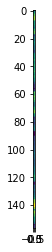

In [27]:
%matplotlib inline
plt.imshow(X_train[0,0,])

In [28]:
X_train[0].shape
# X_train[0].reshape(1, 96, 157)

(96, 157, 1)

In [29]:
img_rows = 96
img_cols = 157

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(class_names)




(719, 96, 157, 1)
(719, 12)
(185, 96, 157, 1)
(185, 12)
['Creative, Passionate', 'Criticism, Cynicism', 'Defensivness, Anxiety', 'Friendly, Warm', 'Hostility, Anger', 'Leadership, Charisma', 'Loneliness, Unfulfillment', 'Love, Happiness', 'Sadness, Sorrow', 'Self-Control, Practicality', 'Supremacy, Arrogance', 'Unknown']


In [35]:
# make the model
model = build_model(X_train,Y_train, nb_classes=len(class_names))


/Users/Chen/anaconda/envs/clevo_py3/lib/python3.5/site-packages/ipykernel_launcher.py:187: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(96, 157, ..., padding="valid")`
/Users/Chen/anaconda/envs/clevo_py3/lib/python3.5/site-packages/ipykernel_launcher.py:193: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`


In [36]:
model.compile(loss='categorical_crossentropy',
          optimizer='adadelta',
          metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 155, 32)       320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 94, 155, 32)       128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 155, 32)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 92, 153, 32)       9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 92, 153, 32)       128       
_________________________________________________________________
elu_1 (ELU)                  (None, 92, 153, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 76, 32)        0         
__________

In [ ]:
# Initialize weights using checkpoint if it exists. (Checkpointing requires h5py)
load_checkpoint = True
checkpoint_filepath = 'weights.hdf5'
if (load_checkpoint):
    print("Looking for previous weights...")
    if ( isfile(checkpoint_filepath) ):
        print ('Checkpoint file detected. Loading weights.')
        model.load_weights(checkpoint_filepath)
    else:
        print ('No checkpoint file detected.  Starting from scratch.')
else:
    print('Starting from scratch (no checkpoint)')
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_best_only=True)


# train and score the model
batch_size = 128
nb_epoch = 100
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
      verbose=1, validation_data=(X_test, Y_test), callbacks=[checkpointer])
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Looking for previous weights...
No checkpoint file detected.  Starting from scratch.
Train on 719 samples, validate on 185 samples
Epoch 1/100


/Users/Chen/anaconda/envs/clevo_py3/lib/python3.5/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


719/719 [==============================] - 59s - loss: 3.5473 - acc: 0.1989 - val_loss: 2.3028 - val_acc: 0.1730
Epoch 2/100
719/719 [==============================] - 61s - loss: 2.3440 - acc: 0.2378 - val_loss: 2.1441 - val_acc: 0.2703
Epoch 3/100
719/719 [==============================] - 64s - loss: 2.2179 - acc: 0.2823 - val_loss: 2.1394 - val_acc: 0.2270
Epoch 4/100
719/719 [==============================] - 68s - loss: 2.2249 - acc: 0.2643 - val_loss: 2.1062 - val_acc: 0.2757
Epoch 5/100
719/719 [==============================] - 70s - loss: 2.2258 - acc: 0.2378 - val_loss: 2.1111 - val_acc: 0.2757
Epoch 6/100
719/719 [==============================] - 76s - loss: 2.1754 - acc: 0.2656 - val_loss: 2.1462 - val_acc: 0.2703
Epoch 7/100
719/719 [==============================] - 66s - loss: 2.1425 - acc: 0.2601 - val_loss: 2.1249 - val_acc: 0.2649
Epoch 8/100
719/719 [==============================] - 76s - loss: 2.1304 - acc: 0.2740 - val_loss: 2.0820 - val_acc: 0.2865
Epoch 9/100


719/719 [==============================] - 85s - loss: 1.8262 - acc: 0.3408 - val_loss: 2.2469 - val_acc: 0.3081
Epoch 34/100
719/719 [==============================] - 78s - loss: 1.8114 - acc: 0.3463 - val_loss: 2.0971 - val_acc: 0.2973
Epoch 35/100
719/719 [==============================] - 81s - loss: 1.8387 - acc: 0.3241 - val_loss: 2.0793 - val_acc: 0.2919
Epoch 36/100
719/719 [==============================] - 87s - loss: 1.7778 - acc: 0.3533 - val_loss: 2.0809 - val_acc: 0.2973
Epoch 37/100
719/719 [==============================] - 89s - loss: 1.7545 - acc: 0.3853 - val_loss: 2.1070 - val_acc: 0.2973
Epoch 38/100
719/719 [==============================] - 76s - loss: 1.7733 - acc: 0.3658 - val_loss: 2.1569 - val_acc: 0.2595
Epoch 39/100
719/719 [==============================] - 75s - loss: 1.7319 - acc: 0.3644 - val_loss: 2.1123 - val_acc: 0.2486
Epoch 40/100
384/719 [===============>..............] - ETA: 28s - loss: 1.6883 - acc: 0.3490